# Load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import math
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score
import xgboost as xgb
import lightgbm as lgb
import gc
import os
import random

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# set all random seeds for reproducibility
np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

In [2]:
data_folder = '/kaggle/input/ieee-fraud-detection/'

train_identity = pd.read_csv(f'{data_folder}train_identity.csv')
train_transaction = pd.read_csv(f'{data_folder}train_transaction.csv')
test_identity = pd.read_csv(f'{data_folder}test_identity.csv')
test_transaction = pd.read_csv(f'{data_folder}test_transaction.csv')

In [3]:
# let's combine the data and work with the whole dataset
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


In [4]:
del train_identity, train_transaction, test_identity, test_transaction

In [5]:
# replace - to _ in column names to keep consistent naming
train.columns = [col.replace('-', '_') for col in train.columns]
test.columns = [col.replace('-', '_') for col in test.columns]

In [6]:
# Convert TransactionDT to days
train['TransactionDay'] = train['TransactionDT'] / (24*60*60)
test['TransactionDay'] = test['TransactionDT'] / (24*60*60)
# create 'day of week' categorical feature
train['day_of_week'] = train['TransactionDT']//3600//24 % 7
test['day_of_week'] = train['TransactionDT']//3600//24 % 7
# create 'hour of day' categorical feature
train['hour_of_day'] = train['TransactionDT']//3600 % 24
test['hour_of_day'] = test['TransactionDT']//3600 % 24

In [7]:
# create decimal places columns (since decimal places might indicate currency conversion)
train['DecimalPlaces'] = train['TransactionAmt'].apply(lambda x: len(str(x).split('.')[-1]) if '.' in str(x) else 0)
test['DecimalPlaces'] = test['TransactionAmt'].apply(lambda x: len(str(x).split('.')[-1]) if '.' in str(x) else 0)
# create cents column
train["cents"] = ((train["TransactionAmt"] % 1) * 100).round().astype(int)
test['cents'] = ((test["TransactionAmt"] % 1) * 100).round().astype(int)

In [8]:
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]
v += [96, 98, 99, 104]
v += [107, 108, 111, 115, 117, 120, 121, 123]
v += [124, 127, 129, 130, 136]
v += [138, 139, 142, 147, 156, 162]
v += [165, 160, 166]
v += [178, 176, 173, 182]
v += [187, 203, 205, 207, 215]
v += [169, 171, 175, 180, 185, 188, 198, 210, 209]
v += [218, 223, 224, 226, 228, 229, 235]
v += [240, 258, 257, 253, 252, 260, 261]
v += [264, 266, 267, 274, 277]
v += [220, 221, 234, 238, 250, 271]
v += [294, 284, 285, 286, 291, 297]
v += [303, 305, 307, 309, 310, 320]
v += [281, 283, 289, 296, 301, 314]
v += [332, 325, 335, 338]
v_features = [f'V{i}' for i in v if f'V{i}' in train.columns]
v_data = train[v_features]
#for PCA 
v_data_clean = v_data.fillna(-1)

# Prep

In [9]:
def encode_AG_numeric(main_columns, agg_cols, train_df=None, test_df=None, fillna=True, usena=False):
    """
    Efficiently create group-based statistical features
    and relative-difference-from-mean features.

    Example:
        For each group of agg_cols, compute mean(A), std(A),
        and (A - mean(A)) / std(A) for rows in that group.
    """
    for main_col in main_columns:
        mean_col_name = f"{'_'.join(agg_cols)}_{main_col}_mean"
        std_col_name = f"{'_'.join(agg_cols)}_{main_col}_std"
        rel_col = f"{'_'.join(agg_cols)}_{main_col}_rel"

        print(f"Computing MEAN/STD of {main_col} grouped by {agg_cols} ...")

        tmp = pd.concat([train_df[agg_cols + [main_col]], test_df[agg_cols + [main_col]]],
                        axis=0, ignore_index=True)
        if usena:
            tmp.loc[tmp[main_col] == -1, main_col] = np.nan

        mean_map = tmp.groupby(agg_cols, as_index=False)[main_col].mean().rename(columns={main_col: mean_col_name})
        std_map = tmp.groupby(agg_cols, as_index=False)[main_col].std().fillna(0).rename(columns={main_col: std_col_name})

        train_df = train_df.merge(mean_map, on=agg_cols, how='left')
        train_df = train_df.merge(std_map, on=agg_cols, how='left')
        test_df = test_df.merge(mean_map, on=agg_cols, how='left')
        test_df = test_df.merge(std_map, on=agg_cols, how='left')

        if fillna:
            train_df[mean_col_name].fillna(-1, inplace=True)
            test_df[mean_col_name].fillna(-1, inplace=True)
            train_df[std_col_name].fillna(-1, inplace=True)
            test_df[std_col_name].fillna(-1, inplace=True)

        # Relative deviation feature
        train_df[rel_col] = ((train_df[main_col] - train_df[mean_col_name]) /
                             train_df[std_col_name].replace(0, np.nan)).astype('float32')
        test_df[rel_col] = ((test_df[main_col] - test_df[mean_col_name]) /
                            test_df[std_col_name].replace(0, np.nan)).astype('float32')

        print(f"   → Added '{mean_col_name}', '{std_col_name}', and '{rel_col}'")

    return train_df, test_df

# group aggregation for categorical features
def encode_AG_cat(main_columns, uids, train_df=train, test_df=test):
    """
    Efficiently encode user-based aggregation features:
    - *_ct  : number of distinct main_column values per UID (behavioral diversity)
    - *_freq: frequency of each main_column value within UID (contextual typicality)

    Parameters
    ----------
    main_columns : list[str]
        Feature names whose diversity/frequency we want to compute (e.g., ['card1', 'P_emaildomain'])
    uids : list[str]
        UID-like columns to group by (e.g., ['uid', 'uid2', 'uid3'])
    train_df : pd.DataFrame
        Training dataframe
    test_df : pd.DataFrame
        Test dataframe (used for consistent mapping)
    """
    for main_col in main_columns:
        for uid in uids:
            print(f"Encoding features for pair: ({uid}, {main_col}) ...")

            # Combine train+test for consistent mappings
            comb = pd.concat([train_df[[uid, main_col]], test_df[[uid, main_col]]], axis=0, ignore_index=True)

            # ---- Diversity (unique count per UID) ----
            diversity = comb.groupby(uid)[main_col].nunique().rename(f"{uid}_{main_col}_ct").astype('float32').reset_index()

            # ---- Frequency (count of each value per UID) ----
            freq = comb.groupby([uid, main_col]).size().rename(f"{uid}_{main_col}_freq").astype('float32').reset_index()

            # Merge diversity into train/test
            train_df = train_df.merge(diversity, on=uid, how='left')
            test_df = test_df.merge(diversity, on=uid, how='left')

            # Merge frequency into train/test
            train_df = train_df.merge(freq, on=[uid, main_col], how='left')
            test_df = test_df.merge(freq, on=[uid, main_col], how='left')

            print(f"   → Added: {uid}_{main_col}_ct and {uid}_{main_col}_freq")

    return train_df, test_df

In [10]:
target = train['isFraud']
train.drop('isFraud', axis=1, inplace=True)

In [11]:
pca = PCA(n_components=13).fit(v_data_clean)
v_data_pca = pca.transform(v_data_clean)
v_pca_cols = [f'V_PCA_{i+1}' for i in range(v_data_pca.shape[1])]
v_data_pca_df = pd.DataFrame(v_data_pca, columns=v_pca_cols)
v_data_pca_df.index = v_data_clean.index

train = pd.concat([train, v_data_pca_df], axis=1)

# drop original V features
v_all = [f'V{i}' for i in range(340) if f'V{i}' in train.columns]
train.drop(v_all, axis=1, inplace=True)

# apply same PCA transformation to test set
v_data_test = test[v_features]
v_data_test_clean = v_data_test.fillna(1)
v_data_test_pca = pca.transform(v_data_test_clean)
v_data_test_pca_df = pd.DataFrame(v_data_test_pca, columns=v_pca_cols)
v_data_test_pca_df.index = v_data_test.index
test = pd.concat([test, v_data_test_pca_df], axis=1)
test.drop(v_all, axis=1, inplace=True)

In [12]:
train['uid'] = train['card1'].astype(str)+'_'+train['addr1'].astype(str)+'_'+np.floor(train['TransactionDay']-train['D1']).astype(str)
test['uid'] = test['card1'].astype(str)+'_'+test['addr1'].astype(str)+'_'+np.floor(test['TransactionDay']-test['D1']).astype(str)

In [13]:
# get transaction dt interval for each uid 
# 1. Add identifiers
train["origin"] = "train"
test["origin"] = "test"
train["original_index"] = train.index
test["original_index"] = test.index

# 2. Combine
full = pd.concat([train, test], ignore_index=True)

# 3. Sort
full = full.sort_values(["uid", "TransactionDT"])

# 4. Compute feature
full["time_since_prev"] = full.groupby("uid")["TransactionDT"].diff()

# 5. Split back
train = full[full["origin"] == "train"].sort_values("original_index").drop(columns=["origin", "original_index"])
test  = full[full["origin"] == "test"].sort_values("original_index").drop(columns=["origin", "original_index"])

In [14]:
del full

In [15]:
#split email domains
train[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = train['P_emaildomain'].str.split('.', expand=True)
train[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = train['R_emaildomain'].str.split('.', expand=True)
test[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = test['P_emaildomain'].str.split('.', expand=True)
test[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = test['R_emaildomain'].str.split('.', expand=True)

In [16]:
num_cols = np.array(train.select_dtypes(exclude=['object','category']).columns)
num_cols

array(['TransactionID', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7',
       'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'id_01',
       'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_13', 'id_14', 'id_17', 'id_18',
       'id_19', 'id_20', 'id_21', 'id_22', 'id_24', 'id_25', 'id_26',
       'id_32', 'TransactionDay', 'day_of_week', 'hour_of_day',
       'DecimalPlaces', 'cents', 'V_PCA_1', 'V_PCA_2', 'V_PCA_3',
       'V_PCA_4', 'V_PCA_5', 'V_PCA_6', 'V_PCA_7', 'V_PCA_8', 'V_PCA_9',
       'V_PCA_10', 'V_PCA_11', 'V_PCA_12', 'V_PCA_13', 'time_since_prev'],
      dtype=object)

In [17]:
cat_cols = np.array(train.select_dtypes(include=['object','category']).columns)
cat_cols

array(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain',
       'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12',
       'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo', 'uid', 'P_emaildomain_1',
       'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1',
       'R_emaildomain_2', 'R_emaildomain_3'], dtype=object)

In [18]:
train, test = encode_AG_numeric(['TransactionAmt'], ['card1'], train_df=train, test_df=test)
train, test = encode_AG_numeric(['TransactionAmt'], ['card4'], train_df=train, test_df=test)
train, test = encode_AG_numeric(['TransactionAmt'], ['card6'], train_df=train, test_df=test)
train, test = encode_AG_numeric(['TransactionAmt'], ['ProductCD'], train_df=train, test_df=test)
train, test = encode_AG_numeric(['TransactionAmt'],['uid','day_of_week'],train_df=train,test_df=test)
train, test = encode_AG_numeric(['TransactionAmt'],['uid','hour_of_day'],train_df=train,test_df=test)
train, test = encode_AG_numeric(['id_02','D15'], ['card1'], train_df=train, test_df=test)
train, test = encode_AG_numeric(['id_02','D15'], ['card4'], train_df=train, test_df=test)
train, test = encode_AG_numeric(['D15'], ['addr1'], train_df=train, test_df=test)
train, test = encode_AG_numeric(['D15'], ['addr2'], train_df=train, test_df=test)

Computing MEAN/STD of TransactionAmt grouped by ['card1'] ...
   → Added 'card1_TransactionAmt_mean', 'card1_TransactionAmt_std', and 'card1_TransactionAmt_rel'
Computing MEAN/STD of TransactionAmt grouped by ['card4'] ...
   → Added 'card4_TransactionAmt_mean', 'card4_TransactionAmt_std', and 'card4_TransactionAmt_rel'
Computing MEAN/STD of TransactionAmt grouped by ['card6'] ...
   → Added 'card6_TransactionAmt_mean', 'card6_TransactionAmt_std', and 'card6_TransactionAmt_rel'
Computing MEAN/STD of TransactionAmt grouped by ['ProductCD'] ...
   → Added 'ProductCD_TransactionAmt_mean', 'ProductCD_TransactionAmt_std', and 'ProductCD_TransactionAmt_rel'
Computing MEAN/STD of TransactionAmt grouped by ['uid', 'day_of_week'] ...
   → Added 'uid_day_of_week_TransactionAmt_mean', 'uid_day_of_week_TransactionAmt_std', and 'uid_day_of_week_TransactionAmt_rel'
Computing MEAN/STD of TransactionAmt grouped by ['uid', 'hour_of_day'] ...
   → Added 'uid_hour_of_day_TransactionAmt_mean', 'uid_hour_o

In [19]:
num_cols_list = num_cols.tolist()
num_cols_list.remove('TransactionID')
num_cols_list.remove('TransactionDT')
num_cols_list.remove('TransactionDay')
# remove cols used to create uid
num_cols_list.remove('addr1')
num_cols_list.remove('card1')
num_cols_list.remove('D1')
train, test = encode_AG_numeric([x for x in num_cols_list if not x.startswith("V")],['uid'],train_df=train,test_df=test)

Computing MEAN/STD of TransactionAmt grouped by ['uid'] ...
   → Added 'uid_TransactionAmt_mean', 'uid_TransactionAmt_std', and 'uid_TransactionAmt_rel'
Computing MEAN/STD of card2 grouped by ['uid'] ...
   → Added 'uid_card2_mean', 'uid_card2_std', and 'uid_card2_rel'
Computing MEAN/STD of card3 grouped by ['uid'] ...
   → Added 'uid_card3_mean', 'uid_card3_std', and 'uid_card3_rel'
Computing MEAN/STD of card5 grouped by ['uid'] ...
   → Added 'uid_card5_mean', 'uid_card5_std', and 'uid_card5_rel'
Computing MEAN/STD of addr2 grouped by ['uid'] ...
   → Added 'uid_addr2_mean', 'uid_addr2_std', and 'uid_addr2_rel'
Computing MEAN/STD of dist1 grouped by ['uid'] ...
   → Added 'uid_dist1_mean', 'uid_dist1_std', and 'uid_dist1_rel'
Computing MEAN/STD of dist2 grouped by ['uid'] ...
   → Added 'uid_dist2_mean', 'uid_dist2_std', and 'uid_dist2_rel'
Computing MEAN/STD of C1 grouped by ['uid'] ...
   → Added 'uid_C1_mean', 'uid_C1_std', and 'uid_C1_rel'
Computing MEAN/STD of C2 grouped by ['ui

In [20]:
train, test = encode_AG_cat([x for x in cat_cols if x != 'uid'], uids=['uid'], train_df=train, test_df=test)

Encoding features for pair: (uid, ProductCD) ...
   → Added: uid_ProductCD_ct and uid_ProductCD_freq
Encoding features for pair: (uid, card4) ...
   → Added: uid_card4_ct and uid_card4_freq
Encoding features for pair: (uid, card6) ...
   → Added: uid_card6_ct and uid_card6_freq
Encoding features for pair: (uid, P_emaildomain) ...
   → Added: uid_P_emaildomain_ct and uid_P_emaildomain_freq
Encoding features for pair: (uid, R_emaildomain) ...
   → Added: uid_R_emaildomain_ct and uid_R_emaildomain_freq
Encoding features for pair: (uid, M1) ...
   → Added: uid_M1_ct and uid_M1_freq
Encoding features for pair: (uid, M2) ...
   → Added: uid_M2_ct and uid_M2_freq
Encoding features for pair: (uid, M3) ...
   → Added: uid_M3_ct and uid_M3_freq
Encoding features for pair: (uid, M4) ...
   → Added: uid_M4_ct and uid_M4_freq
Encoding features for pair: (uid, M5) ...
   → Added: uid_M5_ct and uid_M5_freq
Encoding features for pair: (uid, M6) ...
   → Added: uid_M6_ct and uid_M6_freq
Encoding featur

In [21]:
# drop transaction dt, keep day and hour features
train.drop(['TransactionDT', 'TransactionDay'], axis=1, inplace=True)
test.drop(['TransactionDT', 'TransactionDay'], axis=1, inplace=True)

In [22]:
train.drop(['TransactionID','uid'], axis=1, inplace=True)
test.drop(['uid'], axis=1, inplace=True) #maintain transactionID for submission

In [23]:
#scale numeric cols
scaler = StandardScaler()
num_cols = train.select_dtypes(exclude=['object','category']).columns
# scale and assign back
train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

In [24]:
for c in cat_cols:
    if c in train.columns:
        if train[c].isnull().sum()>0 or test[c].isnull().sum()>0:
            train[c].fillna('missing', inplace=True)
            test[c].fillna('missing', inplace=True)
        train[c] = train[c].astype('category')
        test[c] = test[c].astype('category')

In [25]:
print(f"Final set of features, contains {len(train.columns)} features")

Final set of features, contains 415 features


In [ ]:
train.to_csv('/kaggle/working/train_processed.csv', index=False)
test.to_csv('/kaggle/working/test_processed.csv', index=False)
target.to_csv('/kaggle/working/target.csv', index=False)

In [27]:
train.shape, test.shape

((590540, 415), (506691, 416))


# Evaluation Util

In [ ]:
!pip install mlflow

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import mlflow as mlf
import mlflow.xgboost as mlf_xgboost, mlflow.catboost as mlf_catboost, mlflow.lightgbm as mlf_lightgbm, mlflow.sklearn as mlf_sklearn
from pathlib import Path
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    average_precision_score,
    auc,
    precision_recall_fscore_support,
    precision_recall_curve,
    confusion_matrix,
    brier_score_loss
)
from sklearn.calibration import calibration_curve
import tempfile


def eval_function(y_true, y_prob, threshold: float = 0.5) -> float:
    fp = np.sum((y_true == 0) & (y_prob >= threshold))
    fn = np.sum((y_true == 1) & (y_prob < threshold))
    return (100*fn + fp)/len(y_true)
    
def _plot_artifacts(y_true: np.ndarray, y_prob: np.ndarray, out_dir: Path, threshold: float = 0.5) -> dict[str, Path]:
    out_dir.mkdir(parents=True, exist_ok=True)
    paths: dict[str, Path] = {}

    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    p = out_dir / "roc_curve.png"
    plt.savefig(p, bbox_inches="tight", dpi=150)
    plt.close()
    paths["roc_curve"] = p

    # PR
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(rec, prec)
    plt.figure()
    plt.plot(rec, prec, label=f"PR curve (AP = {pr_auc:.4f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")
    p = out_dir / "pr_curve.png"
    plt.savefig(p, bbox_inches="tight", dpi=150)
    plt.close()
    paths["pr_curve"] = p

    # Confusion matrix @ 0.5
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix @ {threshold}")
    plt.colorbar()
    ticks = np.arange(2)
    plt.xticks(ticks, ["Non-Fraud", "Fraud"], rotation=45)
    plt.yticks(ticks, ["Non-Fraud", "Fraud"])
    thresh = cm.max() / 2.0 if cm.size else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], "d"), ha="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    p = out_dir / "confusion_matrix.png"
    plt.tight_layout()
    plt.savefig(p, bbox_inches="tight", dpi=150)
    plt.close()
    paths["confusion_matrix"] = p

    return paths

def evaluate_and_log(
    model,
    X_va: pd.DataFrame,
    y_va: pd.Series,
    experiment_name: str,
    run_name: str,
    model_type: str | None = None,
    best_params: dict | None = None,
    tracking_uri: str = "mlruns",
    prediction_threshold: float = 0.5,
):
    # --- Detect model type automatically if not provided ---
    if model_type is None:
        cname = model.__class__.__name__.lower()
        if "xgb" in cname:
            model_type = "xgboost"
        elif "cat" in cname:
            model_type = "catboost"
        elif "lgb" in cname:
            model_type = "lightgbm"
        else:
            model_type = "sklearn"

    if prediction_threshold != 0.5: 
        run_name = f"{run_name}_threshold_{prediction_threshold}"

    mlf.set_tracking_uri(tracking_uri)
    mlf.set_experiment(experiment_name)

    with tempfile.TemporaryDirectory() as td, mlf.start_run(run_name=run_name):
        # Tag model type and Optuna params
        mlf.set_tag("model_type", model_type)
        if best_params:
            for k, v in best_params.items():
                mlf.log_param(k, v)

        # --- Predictions ---
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_va)[:, 1]
        else:
            y_prob = model.predict(X_va)
        y_pred = (y_prob >= prediction_threshold).astype(int)

        # --- Metrics ---
        # ROC-AUC and PR-AUC are computed on probabilities (threshold-independent)
        roc_auc = roc_auc_score(y_va, y_prob)
        pr_auc = average_precision_score(y_va, y_prob)
        # Custom loss and classification metrics use the specified threshold
        custom_loss = eval_function(y_va, y_prob, threshold=prediction_threshold)
        precision, recall, f1, _ = precision_recall_fscore_support(y_va, y_pred, average="binary")
        metrics = {
            "roc_auc": roc_auc,
            "pr_auc": pr_auc,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "custom_loss": custom_loss
        }
        mlf.log_metrics(metrics)
        print(f"[INFO] Logged metrics: {metrics}")
        artifacts_dir = Path(td)
        plot_paths = _plot_artifacts(y_va, y_prob, artifacts_dir / "plots", threshold=prediction_threshold)
        for name, path in plot_paths.items():
            mlf.log_artifact(str(path), artifact_path="plots")

        # --- SHAP Explainability ---
        try:
            fraud_idx = np.where(y_va == 1)[0]
            nonfraud_idx = np.where(y_va == 0)[0]
            n = min(len(fraud_idx), len(nonfraud_idx), 500)
            sel_idx = np.concatenate([
                np.random.choice(fraud_idx, size=n, replace=False),
                np.random.choice(nonfraud_idx, size=n, replace=False)
            ])
            np.random.shuffle(sel_idx)
            X_shap = X_va.iloc[sel_idx].reset_index(drop=True)
            y_shap = y_va.iloc[sel_idx].reset_index(drop=True)

            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_shap, check_additivity=False)

            plt.figure()
            shap.summary_plot(shap_values, X_shap, show=False)
            mlf.log_figure(plt.gcf(), "explainability/shap_summary.png")
            plt.close()
            print("[INFO] Logged SHAP summary plot.")
        except Exception as e:
            print(f"[WARN] SHAP skipped: {e}")

        # --- Log Model ---
        try:
            # Prefer generic API when available
            mlf.log_model(model, name="model")
        except Exception:
            # Fallback to flavor-specific APIs
            try:
                if model_type == "xgboost":
                    mlf_xgboost.log_model(model, name="model")
                elif model_type == "catboost":
                    mlf_catboost.log_model(model, name="model")
                elif model_type == "lightgbm":
                    mlf_lightgbm.log_model(model, name="model")
                else:
                    mlf_sklearn.log_model(model, name="model")
            except Exception as e:
                print(f"[WARN] Could not log model: {e}")

        print("[INFO] Evaluation complete and logged.")
    return metrics

# Training

In [33]:
cat_cols = np.array(train.select_dtypes(include=['object']).columns)
for c in cat_cols:
    if c in train.columns:
        if train[c].isnull().sum()>0 or test[c].isnull().sum()>0:
            train[c].fillna('missing', inplace=True)
            test[c].fillna('missing', inplace=True)
        train[c] = train[c].astype('category')
        test[c] = test[c].astype('category')

In [34]:
# attempt without suffle, since the data have time relation
n = len(train)
split_idx = int(n * 0.8)  # 4/5 split

X_train = train.iloc[:split_idx]
y_train = target.iloc[:split_idx]
X_valid = train.iloc[split_idx:]
y_valid = target.iloc[split_idx:]

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score
)
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb

In [36]:
def _gpu_available() -> bool:
    """Check if GPU is available for XGBoost training.
    
    Attempts to create and fit a minimal XGBoost model with GPU acceleration.
    If successful, GPU is available; otherwise, falls back to CPU.
    
    Returns:
        bool: True if GPU is available and working with XGBoost, False otherwise.
    
    Example:
        >>> use_gpu = _gpu_available()
        >>> print(f"GPU acceleration available: {use_gpu}")
    """
    try:
        # Attempt a tiny GPU-boosted fit; if it fails, fall back to CPU
        clf = xgb.XGBClassifier(
            n_estimators=1,
            tree_method="gpu_hist",
            max_depth=1,
            verbosity=0,
        )
        clf.fit(np.array([[0.0], [1.0]]), np.array([0, 1]))
        return True
    except Exception:
        return False


def _scale_pos_weight(y: np.ndarray, factor = 1.0) -> float:
    """Calculate scaling factor for positive class weight in imbalanced datasets.
    
    Args:
        y: Array of binary labels (0 or 1).
        factor: Multiplier factor to adjust the scale of the weight. Defaults to 1.
        
    Returns:
        float: Ratio of negative to positive samples, used to balance class weights.
        
    Example:
        >>> y = np.array([0, 0, 0, 1])  # imbalanced dataset
        >>> weight = _scale_pos_weight(y)
        >>> print(f"Positive class weight scaling: {weight}")  # would print 3.0
    """
    pos = np.sum(y == 1)
    neg = np.sum(y == 0)
    return factor*float(neg / max(1, pos))

## XGBoost

In [37]:
def train_xgb_manual(X_train, y_train, X_valid, y_valid, random_state=42, early_stopping_rounds=50, use_gpu=True):
    
    # Define custom learning rate schedule
    def custom_learning_rate(current_iter):
        base_learning_rate = 0.1
        lr = base_learning_rate * np.power(0.999, current_iter)
        if lr < 0.01 : lr = 0.01
        return lr
    lr_scheduler = xgb.callback.LearningRateScheduler(custom_learning_rate)
    
    model = None
    params = {
        "n_estimators": 50000,
        "max_depth": 3,
        "colsample_bytree": 0.7,
        "lambda": 20,
        "alpha": 10,
        "min_child_weight": 10,
        "gamma": 2,
        "tree_method": "gpu_hist" if  _gpu_available() and use_gpu else "hist",
        "objective": "binary:logistic",
        "eval_metric": "aucpr",
        "scale_pos_weight": _scale_pos_weight(y_train),
        "n_jobs": -1,
        "random_state": random_state,
    }
    model = xgb.XGBClassifier(**params,
                              verbosity=2, 
                              early_stopping_rounds=early_stopping_rounds,
                              enable_categorical=True)
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=500,   # print every 100 boosting rounds
        callbacks=[lr_scheduler],
    )
    
    # ---- PLOT ----
    evals_result = model.evals_result()
    train_curve = evals_result["validation_0"]["aucpr"]
    valid_curve = evals_result["validation_1"]["aucpr"]

    plt.figure(figsize=(12, 6))
    plt.plot(train_curve, label="Train PR-AUC", alpha=0.8)
    plt.plot(valid_curve, label="Validation PR-AUC", alpha=0.8)
    plt.title("XGBoost Training vs Validation PR-AUC with Data-Driven LR")
    plt.xlabel("Boosting Rounds")
    plt.ylabel("PR-AUC")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
    return model

[0]	validation_0-aucpr:0.18915	validation_1-aucpr:0.18926
[500]	validation_0-aucpr:0.67074	validation_1-aucpr:0.48690
[1000]	validation_0-aucpr:0.71624	validation_1-aucpr:0.51138
[1500]	validation_0-aucpr:0.73932	validation_1-aucpr:0.52137
[2000]	validation_0-aucpr:0.75116	validation_1-aucpr:0.52553
[2500]	validation_0-aucpr:0.75826	validation_1-aucpr:0.52842
[3000]	validation_0-aucpr:0.76483	validation_1-aucpr:0.53093
[3500]	validation_0-aucpr:0.77070	validation_1-aucpr:0.53297
[4000]	validation_0-aucpr:0.77689	validation_1-aucpr:0.53586
[4500]	validation_0-aucpr:0.78215	validation_1-aucpr:0.53803
[5000]	validation_0-aucpr:0.78751	validation_1-aucpr:0.53996
[5500]	validation_0-aucpr:0.79292	validation_1-aucpr:0.54218
[6000]	validation_0-aucpr:0.79814	validation_1-aucpr:0.54393
[6500]	validation_0-aucpr:0.80271	validation_1-aucpr:0.54558
[7000]	validation_0-aucpr:0.80762	validation_1-aucpr:0.54730
[7500]	validation_0-aucpr:0.81240	validation_1-aucpr:0.54931
[8000]	validation_0-aucpr:0.

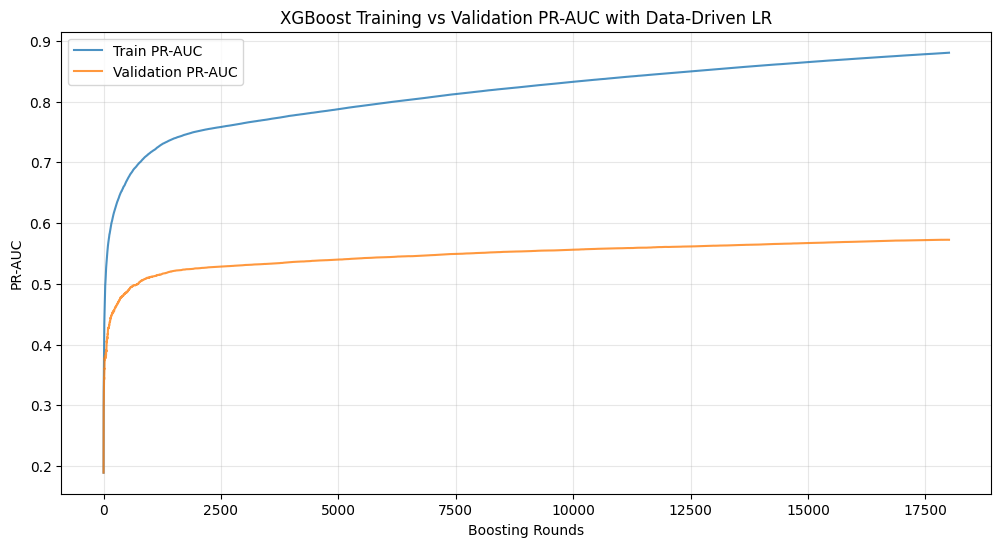

In [38]:
model_xgboost_full = train_xgb_manual(X_train, y_train, X_valid, y_valid, early_stopping_rounds=200)

In [39]:
evaluate_and_log(model_xgboost_full, X_valid, y_valid, experiment_name="fraud_detection_kaggle", run_name="XGB_Full")

2025/12/07 15:39:23 INFO mlflow.tracking.fluent: Experiment with name 'fraud_detection_kaggle' does not exist. Creating a new experiment.


[INFO] Logged metrics: {'roc_auc': 0.9309070225727216, 'pr_auc': 0.5726734817091049, 'precision': 0.3098562200458429, 'recall': 0.7317913385826772, 'f1': 0.4353681744986093, 'custom_loss': 0.9789684018017408}
[WARN] SHAP skipped: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. Consider retrying with the feature_perturbation='interventional' option. This check failed because for one of the samples the sum of the SHAP values was 4.754465, while the model output was 5.022971. If this difference is acceptable you can set check_additivity=False to disable this check.
[INFO] Evaluation complete and logged.


{'roc_auc': 0.9309070225727216,
 'pr_auc': 0.5726734817091049,
 'precision': 0.3098562200458429,
 'recall': 0.7317913385826772,
 'f1': 0.4353681744986093,
 'custom_loss': 0.9789684018017408}

## LGBM

In [41]:
def train_lgbm_manual(X_train, y_train, X_valid, y_valid,
                      random_state=42, early_stopping_rounds=50, use_gpu=True):

    # ---- CUSTOM LEARNING RATE SCHEDULE ----
    def custom_learning_rate(iteration):
        base_lr = 0.1
        lr = base_lr * np.power(0.999, iteration)
        return max(lr, 0.01)

    def lr_scheduler(iteration):
        return custom_learning_rate(iteration)

    params = {
        "objective": "binary",
        "metric": "average_precision",
        "boosting_type": "gbdt",
        "learning_rate": 0.1,
        "num_leaves": 15,
        "min_child_samples": 10,
        "min_split_gain": 2,
        "subsample": 0.7,
        "colsample_bytree": 0.7,
        "lambda_l1": 10,
        "lambda_l2": 20,
        "n_estimators": 20000,
        "random_state": random_state,
        "verbose": -1,
    }

    if use_gpu:
        params["device"] = "gpu"

    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)

    evals_result = dict()
    
    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, valid_data],
        valid_names=["train", "valid"],
        callbacks=[
            lgb.early_stopping(stopping_rounds=early_stopping_rounds),
            lgb.log_evaluation(period=50),
            lgb.reset_parameter(learning_rate=lr_scheduler),
            lgb.record_evaluation(evals_result)
        ]
    )
    

    train_curve = evals_result["train"]["average_precision"]
    valid_curve = evals_result["valid"]["average_precision"]

    # ---- PLOT ----
    plt.figure(figsize=(12, 6))
    plt.plot(train_curve, label="Train PR-AUC", alpha=0.8)
    plt.plot(valid_curve, label="Validation PR-AUC", alpha=0.8)
    plt.title("LightGBM Training vs Validation PR-AUC with LR Scheduler")
    plt.xlabel("Boosting Rounds")
    plt.ylabel("PR-AUC")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    return model

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 200 rounds
[50]	train's average_precision: 0.628313	valid's average_precision: 0.459093
[100]	train's average_precision: 0.682085	valid's average_precision: 0.491673
[150]	train's average_precision: 0.717535	valid's average_precision: 0.509131
[200]	train's average_precision: 0.742041	valid's average_precision: 0.520171
[250]	train's average_precision: 0.76106	valid's average_precision: 0.529622
[300]	train's average_precision: 0.776714	valid's average_precision: 0.536995
[350]	train's average_precision: 0.790106	valid's average_precision: 0.543861
[400]	train's average_precision: 0.800659	valid's average_precision: 0.549021
[450]	train's average_precision: 0.809258	valid's average_precision: 0.552249
[500]	train's average_precision: 0.816488	valid's average_precision: 0.55523
[550]	train's average_precision: 0.821932	valid's average_precision: 0.558654
[600]	train's average_precision: 0.822713	valid's average_precision: 0.559025
[650]

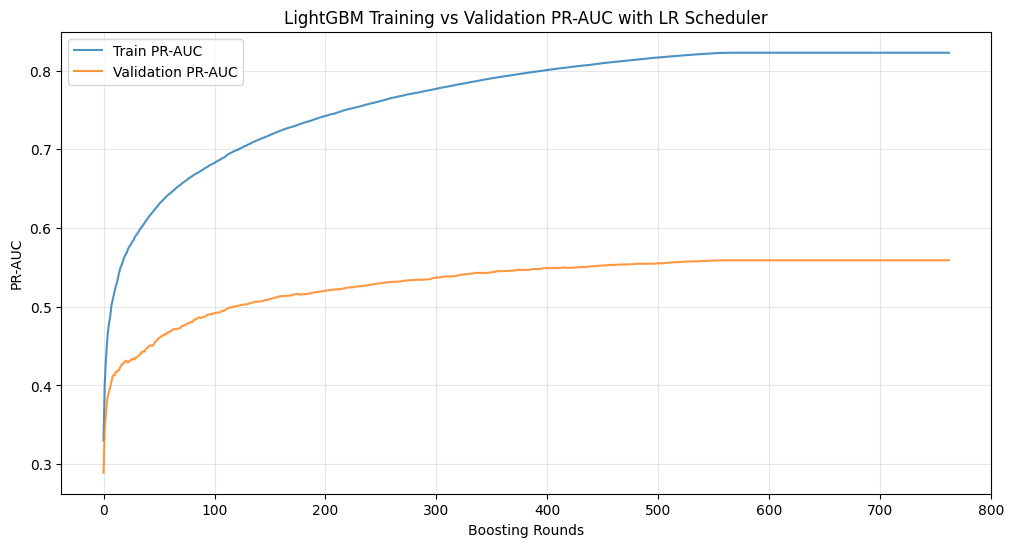

In [42]:
model_lgbm_full = train_lgbm_manual(X_train, y_train, X_valid, y_valid, early_stopping_rounds=200)

In [43]:
evaluate_and_log(model_lgbm_full, X_valid, y_valid, experiment_name="fraud_detection_kaggle", run_name="LGBM_Full")

[INFO] Logged metrics: {'roc_auc': 0.9249400489540299, 'pr_auc': 0.5590438357354359, 'precision': 0.7287822878228782, 'recall': 0.3887795275590551, 'f1': 0.5070603337612324, 'custom_loss': 2.1081383140854135}
[INFO] Logged SHAP summary plot.
[INFO] Evaluation complete and logged.


{'roc_auc': 0.9249400489540299,
 'pr_auc': 0.5590438357354359,
 'precision': 0.7287822878228782,
 'recall': 0.3887795275590551,
 'f1': 0.5070603337612324,
 'custom_loss': 2.1081383140854135}

# Reduce Features

In [44]:
import shap

def get_top_features_shap(model, X, y, max_fraud=5000):
    """
    Computes SHAP feature importance for a trained tree-based model,
    using all (or up to max_fraud) fraud cases and an equal-sized 
    sample of non-fraud cases.

    Parameters
    ----------
    model : trained XGBoost / LightGBM / CatBoost model
    X : pandas DataFrame 
        Input data for SHAP evaluation
    y : pandas Series or array-like
        Ground-truth labels (0 = non-fraud, 1 = fraud)
    max_fraud : int
        Maximum number of fraud examples to include

    Returns
    -------
    DataFrame with columns: feature, importance (sorted)
    """

    # ---------- 1. Build SHAP sample ----------
    fraud_idx = np.where(y == 1)[0]
    nonfraud_idx = np.where(y == 0)[0]

    # limit frauds if too many
    selected_fraud_idx = (
        np.random.choice(fraud_idx, size=min(len(fraud_idx), max_fraud), replace=False)
    )

    # equal-sized non-fraud sample
    selected_nonfraud_idx = (
        np.random.choice(nonfraud_idx, size=len(selected_fraud_idx), replace=False)
    )

    # final sample
    sample_idx = np.concatenate([selected_fraud_idx, selected_nonfraud_idx])
    X_shap = X.iloc[sample_idx]

    # ---------- 2. Build SHAP explainer ----------
    try:
        explainer = shap.TreeExplainer(model)
    except Exception as e:
        raise RuntimeError(
            "Error initializing SHAP TreeExplainer. "
            "Model must be a tree-based model.\n"
            f"Original error: {e}"
        )

    # ---------- 3. Compute SHAP values ----------
    try:
        shap_values = explainer.shap_values(X_shap, check_additivity=False)
    except Exception as e:
        raise RuntimeError(
            "Error computing SHAP values.\n"
            f"Original error: {e}"
        )

    # multi-class output (list) → use class 1
    if isinstance(shap_values, list):
        shap_values = shap_values[1]

    shap_values = np.abs(shap_values)

    # ---------- 4. Compute global importance ----------
    importance = shap_values.mean(axis=0)

    df = pd.DataFrame({
        "feature": X.columns,
        "importance": importance
    }).sort_values("importance", ascending=False)

    return df

In [45]:
# ---- 1. Compute SHAP importance for each model ----
df_xgb = get_top_features_shap(model_xgboost_full, X_train, y_train).rename(
    columns={"importance": "importance_xgb"}
)
df_lgbm = get_top_features_shap(model_lgbm_full, X_train, y_train).rename(
    columns={"importance": "importance_lgbm"}
)

# ---- 2. Merge all importance tables ----
df = (
    df_xgb.merge(df_lgbm, on="feature")
)

# ---- 3. Rank features within each model (1 = most important) ----
df["rank_xgb"] = df["importance_xgb"].rank(method="min", ascending=False)
df["rank_lgbm"] = df["importance_lgbm"].rank(method="min", ascending=False)

# ---- 4. Determine the top 30% threshold ----
n_features = len(df)
top_30_cutoff = int(n_features * 0.30)

# ---- 5. Check if a feature appears in top 30% in each model ----
df["in_top_xgb"]  = df["rank_xgb"]  <= top_30_cutoff
df["in_top_lgbm"] = df["rank_lgbm"] <= top_30_cutoff

# ---- 6. Apply the rule: “Top 30% for at least 2 models” ----
df["top_count"] = (
    df["in_top_xgb"].astype(int)
  + df["in_top_lgbm"].astype(int)
)

df_selected = df[df["top_count"] >= 2]  # final selected features


In [46]:
# ---- 7. Sort by mean importance (optional but nice) ----
df_selected["importance_mean"] = df_selected[["importance_xgb","importance_lgbm"]].mean(axis=1)
df_selected = df_selected.sort_values("importance_mean", ascending=False)

# ---- 8. Save to CSV ----
df.to_csv("/kaggle/working/feature_importances_shap_fullmodels.csv", index=False)
df_selected.to_csv("/kaggle/working/selected_features_shap.csv", index=False)

# ---- 9. List of selected feature names ----
selected_feature_list = df_selected["feature"].tolist()

In [47]:
del df_xgb, df_lgbm, df_selected, df

In [48]:
X_train_reduced = X_train[selected_feature_list]
X_valid_reduced = X_valid[selected_feature_list]
X_train_reduced.shape, X_valid_reduced.shape

((472432, 104), (118108, 104))

In [70]:
test_reduced = test[selected_feature_list + ['TransactionID']]
test_reduced.shape

(506691, 105)

In [49]:
print(selected_feature_list)

['C1', 'uid_M4_freq', 'ProductCD_TransactionAmt_rel', 'uid_time_since_prev_mean', 'C14', 'uid_C13_std', 'uid_D3_mean', 'DeviceInfo', 'uid_C13_rel', 'uid_C13_mean', 'P_emaildomain', 'C13', 'R_emaildomain', 'uid_D2_mean', 'id_31', 'uid_C6_mean', 'uid_time_since_prev_std', 'card1_TransactionAmt_mean', 'C5', 'card1_id_02_std', 'uid_C14_mean', 'card6', 'C11', 'uid_TransactionAmt_mean', 'D3', 'card1_D15_std', 'card1_id_02_mean', 'uid_C2_mean', 'uid_C9_mean', 'card1', 'uid_hour_of_day_std', 'uid_C1_mean', 'id_33', 'card1_TransactionAmt_std', 'uid_day_of_week_std', 'uid_dist1_mean', 'uid_D2_std', 'V_PCA_2', 'uid_C9_std', 'C8', 'uid_M6_freq', 'V_PCA_9', 'id_30', 'uid_D11_std', 'uid_M5_freq', 'V_PCA_4', 'uid_C14_rel', 'M5', 'D8', 'uid_TransactionAmt_std', 'uid_C11_mean', 'D2', 'M6', 'uid_D5_mean', 'hour_of_day', 'uid_D11_mean', 'card2', 'uid_D5_std', 'uid_D10_std', 'card3', 'addr1_D15_std', 'P_emaildomain_1', 'uid_day_of_week_rel', 'uid_hour_of_day_mean', 'C2', 'C12', 'uid_cents_mean', 'uid_P_em

## XGBoost with reduced features

[0]	validation_0-aucpr:0.20800	validation_1-aucpr:0.16250
[500]	validation_0-aucpr:0.66680	validation_1-aucpr:0.49093
[1000]	validation_0-aucpr:0.71412	validation_1-aucpr:0.51009
[1500]	validation_0-aucpr:0.73678	validation_1-aucpr:0.51862
[2000]	validation_0-aucpr:0.74923	validation_1-aucpr:0.52448
[2500]	validation_0-aucpr:0.75641	validation_1-aucpr:0.52805
[3000]	validation_0-aucpr:0.76254	validation_1-aucpr:0.53165
[3500]	validation_0-aucpr:0.76852	validation_1-aucpr:0.53435
[4000]	validation_0-aucpr:0.77419	validation_1-aucpr:0.53682
[4500]	validation_0-aucpr:0.77996	validation_1-aucpr:0.53883
[5000]	validation_0-aucpr:0.78538	validation_1-aucpr:0.54102
[5500]	validation_0-aucpr:0.79047	validation_1-aucpr:0.54338
[6000]	validation_0-aucpr:0.79548	validation_1-aucpr:0.54533
[6500]	validation_0-aucpr:0.80022	validation_1-aucpr:0.54723
[7000]	validation_0-aucpr:0.80473	validation_1-aucpr:0.54899
[7500]	validation_0-aucpr:0.80895	validation_1-aucpr:0.55043
[8000]	validation_0-aucpr:0.

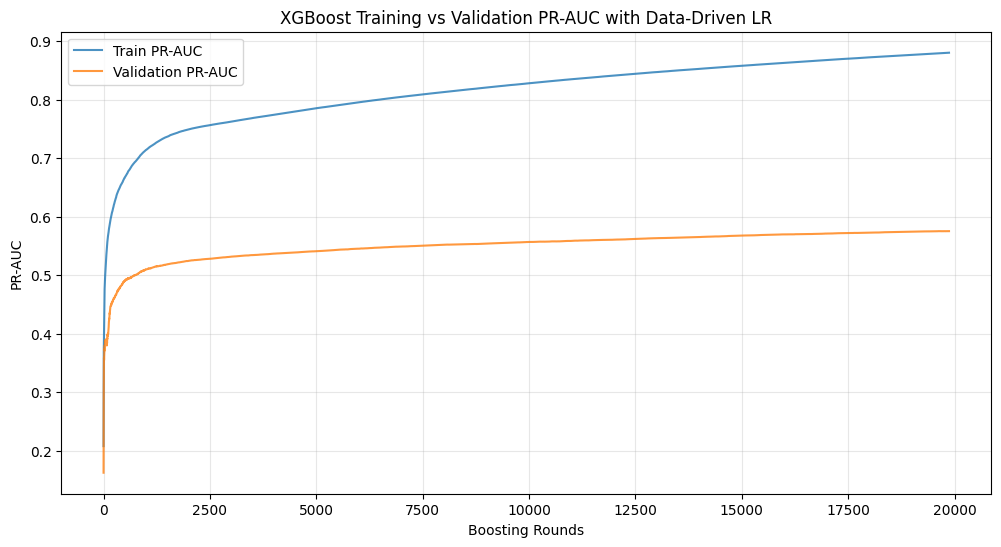

In [50]:
model_xgb_reduced = train_xgb_manual(X_train_reduced, y_train, X_valid_reduced, y_valid, early_stopping_rounds=200)

In [52]:
evaluate_and_log(model_xgb_reduced, X_valid_reduced, y_valid, experiment_name="fraud_detection_kaggle", run_name="XGB_Reduced")

[INFO] Logged metrics: {'roc_auc': 0.9298859099174874, 'pr_auc': 0.5753692972166036, 'precision': 0.3229289150187066, 'recall': 0.7433562992125984, 'f1': 0.4502570981444221, 'custom_loss': 0.93671893521184}
[INFO] Logged SHAP summary plot.
[INFO] Evaluation complete and logged.


{'roc_auc': 0.9298859099174874,
 'pr_auc': 0.5753692972166036,
 'precision': 0.3229289150187066,
 'recall': 0.7433562992125984,
 'f1': 0.4502570981444221,
 'custom_loss': 0.93671893521184}

## LGBM with reduced features

Training until validation scores don't improve for 200 rounds
[50]	train's average_precision: 0.621573	valid's average_precision: 0.449284
[100]	train's average_precision: 0.675921	valid's average_precision: 0.473887
[150]	train's average_precision: 0.709222	valid's average_precision: 0.488609
[200]	train's average_precision: 0.733287	valid's average_precision: 0.500695
[250]	train's average_precision: 0.752724	valid's average_precision: 0.510387
[300]	train's average_precision: 0.768936	valid's average_precision: 0.517474
[350]	train's average_precision: 0.78276	valid's average_precision: 0.524107
[400]	train's average_precision: 0.793196	valid's average_precision: 0.53006
[450]	train's average_precision: 0.801963	valid's average_precision: 0.532645
[500]	train's average_precision: 0.807869	valid's average_precision: 0.535566
[550]	train's average_precision: 0.807869	valid's average_precision: 0.535566
[600]	train's average_precision: 0.807869	valid's average_precision: 0.535566
[650]

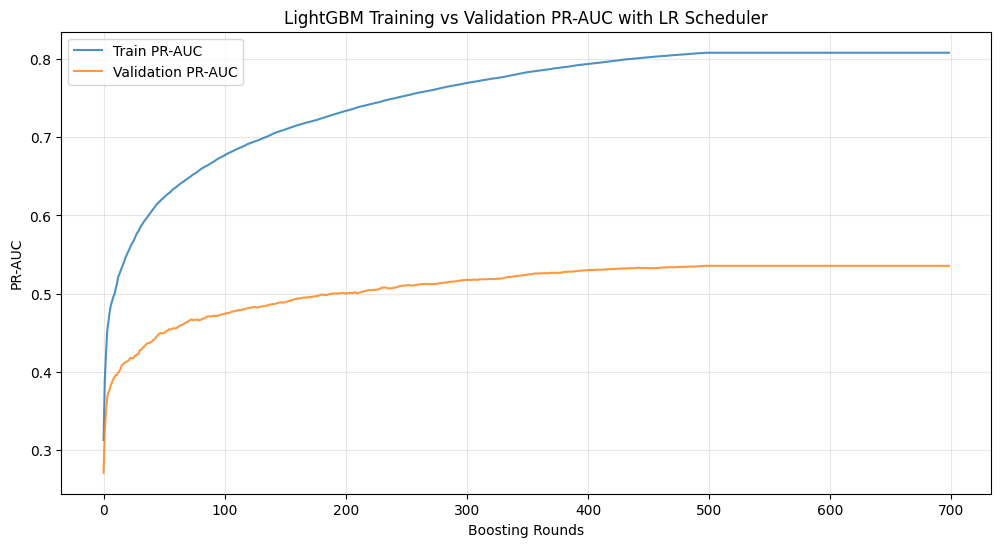

In [53]:
model_lgbm_reduced = train_lgbm_manual(X_train_reduced, y_train, X_valid_reduced, y_valid, early_stopping_rounds=200)

In [54]:
evaluate_and_log(model_lgbm_reduced, X_valid_reduced, y_valid, experiment_name="fraud_detection_kaggle", run_name="LGBM_Reduced")

[INFO] Logged metrics: {'roc_auc': 0.9201411064371617, 'pr_auc': 0.5355745478695342, 'precision': 0.699471915506481, 'recall': 0.35851377952755903, 'f1': 0.474052383276395, 'custom_loss': 2.212602025265012}
[INFO] Logged SHAP summary plot.
[INFO] Evaluation complete and logged.


{'roc_auc': 0.9201411064371617,
 'pr_auc': 0.5355745478695342,
 'precision': 0.699471915506481,
 'recall': 0.35851377952755903,
 'f1': 0.474052383276395,
 'custom_loss': 2.212602025265012}

# Add Anomally Detection Features

In [66]:
import pandas as pd

class HybridEncoder:
    """
    One-hot encode low-cardinality categories.
    Frequency encode high-cardinality categories.
    """

    def __init__(self, max_unique=20):
        self.max_unique = max_unique
        self.low_card_cols = []
        self.high_card_cols = []
        self.freq_maps = {}       # category → frequency

    def fit(self, X):
        X = X.copy()
        cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

        for col in cat_cols:
            nunique = X[col].nunique()

            if nunique <= self.max_unique:
                self.low_card_cols.append(col)
            else:
                self.high_card_cols.append(col)
                # build frequency map for this column
                freq_map = X[col].value_counts()
                self.freq_maps[col] = freq_map

        return self

    def transform(self, X):
        X = X.copy()

        # ---- frequency encoding for high-cardinality columns ----
        for col in self.high_card_cols:
            X[col] = X[col].map(self.freq_maps[col]).fillna(0).astype(float)

        # ---- one-hot encoding for low-cardinality columns ----
        X = pd.get_dummies(X, columns=self.low_card_cols, dummy_na=False)

        return X

    def fit_transform(self, X):
        return self.fit(X).transform(X)

In [75]:
encoder = HybridEncoder(max_unique=20)

X_train_enc = encoder.fit_transform(X_train_reduced).fillna(0)
X_valid_enc = encoder.transform(X_valid_reduced).fillna(0)
X_test_enc  = encoder.transform(test_reduced).fillna(0)

# Mask for normal samples
normal_mask = (y_train == 0)

X_train_normal = X_train_enc[normal_mask]

## Isolation Forest

In [89]:
from sklearn.ensemble import IsolationForest

isof = IsolationForest(
    n_estimators=500,
    contamination="auto",
    n_jobs=-1
)

isof.fit(X_train_enc)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [171]:
anomaly_train = -isof.decision_function(X_train_enc)
anomaly_valid = -isof.decision_function(X_valid_enc)

In [115]:
X_test_enc['card6_debit or credit']=False

In [172]:
anomaly_test = -isof.decision_function(X_test_enc.loc[:,list(X_train_enc.columns)])

In [173]:
X_train_anomaly = X_train_reduced.copy()
X_valid_anomaly = X_valid_reduced.copy()
X_train_anomaly['anomaly_score'] = anomaly_train
X_valid_anomaly['anomaly_score'] = anomaly_valid

In [174]:
X_test_anomaly = test_reduced.copy()
X_test_anomaly['anomaly_score'] = anomaly_test

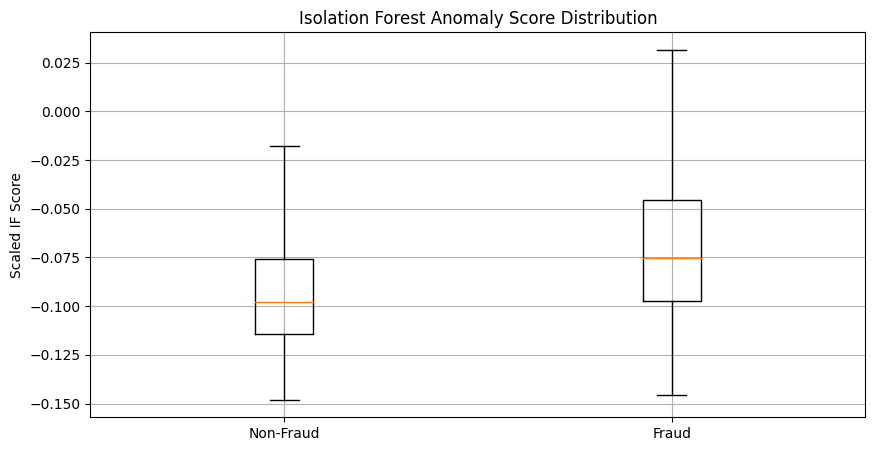

In [175]:
fraud_if = anomaly_train[y_train == 1]
normal_if = anomaly_train[y_train == 0]

plt.figure(figsize=(10, 5))
plt.boxplot([normal_if, fraud_if], labels=["Non-Fraud", "Fraud"], showfliers=False)
plt.title("Isolation Forest Anomaly Score Distribution")
plt.ylabel("Scaled IF Score")
plt.grid(True)
plt.show()


## Autoencoder

In [135]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Keep ONLY normal samples
normal_mask = (y_train == 0)
X_train_normal = X_train_enc[normal_mask]

# Build autoencoder
input_dim = X_train_enc.shape[1]
encoding_dim = 32

inp = tf.keras.layers.Input(shape=(input_dim,))
x = tf.keras.layers.Dense(64, activation='relu')(inp)
x = tf.keras.layers.Dense(32, activation='relu')(x)
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(x)

x = tf.keras.layers.Dense(32, activation='relu')(encoded)
x = tf.keras.layers.Dense(64, activation='relu')(x)
out = tf.keras.layers.Dense(input_dim, activation='linear')(x)

autoencoder = tf.keras.Model(inp, out)

autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='mse'
)

In [136]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,              # epochs with no improvement before stopping
    restore_best_weights=True,
    verbose=1
)

history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=100,              # set a high max and let early stopping cut it
    batch_size=128,
    validation_split=0.1,
    shuffle=True,
    callbacks=[early_stop]
)


Epoch 1/100
3206/3206 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 1387404672.0000 - val_loss: 6038645.0000
Epoch 2/100
3206/3206 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 5172175.0000 - val_loss: 572662.2500
Epoch 3/100
3206/3206 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 699814.7500 - val_loss: 387583.1562
Epoch 4/100
3206/3206 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 435425.2812 - val_loss: 748350.3750
Epoch 5/100
3206/3206 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 361405.9688 - val_loss: 296478.5938
Epoch 6/100
3206/3206 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 306009.1562 - val_loss: 274566.8125
Epoch 7/100
3206/3206 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 273892.4062 - val_loss: 235103.6094
Epoch 8/100
3206/3206 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 246226.8906 - val_loss: 222221.5000
Epoch 9/100
3206/3206 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 205753.2188 - val_loss: 146472.3750
Epoch 10/100
3206/3206 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 138179.7031 - val_loss: 76655.3906
Epo

In [137]:
def compute_ae_score(model, X):
    reconstructed = model.predict(X, verbose=0)
    errors = np.mean(np.square(X - reconstructed), axis=1)  # MSE per sample
    return errors

In [176]:
ae_score_train = compute_ae_score(autoencoder, X_train_enc)
ae_score_valid = compute_ae_score(autoencoder, X_valid_enc)
ae_score_test  = compute_ae_score(autoencoder, X_test_enc.drop(columns=['TransactionID'],axis=0))

<Figure size 1000x600 with 0 Axes>

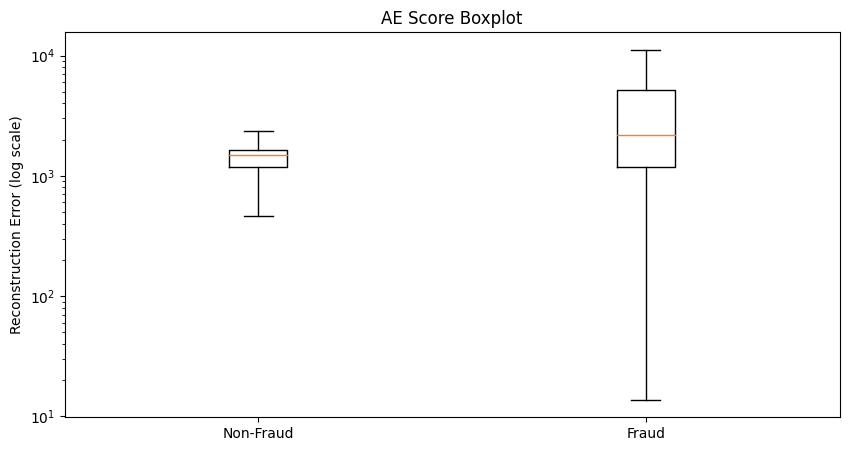

In [177]:
plt.figure(figsize=(10, 6))

# Separate fraud vs non-fraud
fraud_scores = ae_score_train[y_train == 1]
normal_scores = ae_score_train[y_train == 0]

plt.figure(figsize=(10, 5))
plt.boxplot([normal_scores, fraud_scores], labels=["Non-Fraud", "Fraud"], showfliers=False)
plt.yscale("log")
plt.title("AE Score Boxplot")
plt.ylabel("Reconstruction Error (log scale)")
plt.show()

In [178]:
X_train_anomaly["ae_score"] = ae_score_train
X_valid_anomaly["ae_score"] = ae_score_valid
X_test_anomaly["ae_score"] = ae_score_test

## XGBoost with anomaly

[0]	validation_0-aucpr:0.20800	validation_1-aucpr:0.16250
[500]	validation_0-aucpr:0.66592	validation_1-aucpr:0.48534
[1000]	validation_0-aucpr:0.71282	validation_1-aucpr:0.50852
[1500]	validation_0-aucpr:0.73580	validation_1-aucpr:0.51865
[2000]	validation_0-aucpr:0.74827	validation_1-aucpr:0.52438
[2500]	validation_0-aucpr:0.75533	validation_1-aucpr:0.52795
[3000]	validation_0-aucpr:0.76191	validation_1-aucpr:0.53180
[3500]	validation_0-aucpr:0.76782	validation_1-aucpr:0.53465
[4000]	validation_0-aucpr:0.77354	validation_1-aucpr:0.53684
[4500]	validation_0-aucpr:0.77893	validation_1-aucpr:0.53876
[5000]	validation_0-aucpr:0.78430	validation_1-aucpr:0.54053
[5500]	validation_0-aucpr:0.78947	validation_1-aucpr:0.54267
[6000]	validation_0-aucpr:0.79477	validation_1-aucpr:0.54478
[6500]	validation_0-aucpr:0.79917	validation_1-aucpr:0.54617
[7000]	validation_0-aucpr:0.80358	validation_1-aucpr:0.54764
[7500]	validation_0-aucpr:0.80797	validation_1-aucpr:0.54918
[8000]	validation_0-aucpr:0.

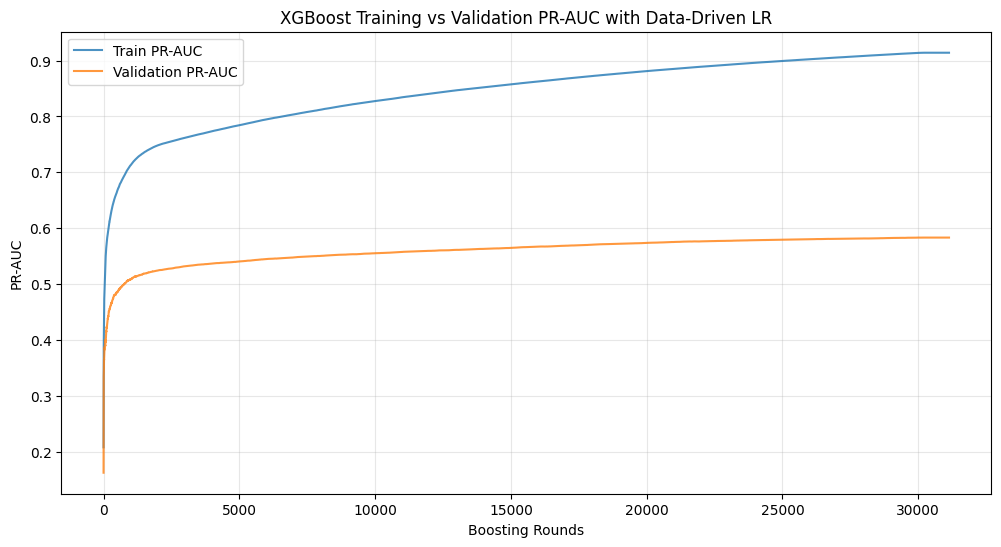

In [186]:
model_xgb_anomaly = train_xgb_manual(X_train_anomaly, y_train, X_valid_anomaly, y_valid, early_stopping_rounds=1000)

In [187]:
evaluate_and_log(model_xgb_anomaly, X_valid_anomaly, y_valid, experiment_name="fraud_detection_kaggle", run_name="XGB_Anomaly")

[INFO] Logged metrics: {'roc_auc': 0.9300355782438026, 'pr_auc': 0.5832812379154916, 'precision': 0.3507453786523554, 'recall': 0.7236712598425197, 'f1': 0.4724877500200819, 'custom_loss': 0.9969180749822196}
[INFO] Logged SHAP summary plot.
[INFO] Evaluation complete and logged.


{'roc_auc': 0.9300355782438026,
 'pr_auc': 0.5832812379154916,
 'precision': 0.3507453786523554,
 'recall': 0.7236712598425197,
 'f1': 0.4724877500200819,
 'custom_loss': 0.9969180749822196}

## LGBM with anomaly 

Training until validation scores don't improve for 1000 rounds
[50]	train's average_precision: 0.622474	valid's average_precision: 0.436911
[100]	train's average_precision: 0.674895	valid's average_precision: 0.476516
[150]	train's average_precision: 0.708137	valid's average_precision: 0.49787
[200]	train's average_precision: 0.733082	valid's average_precision: 0.514026
[250]	train's average_precision: 0.752357	valid's average_precision: 0.522645
[300]	train's average_precision: 0.768175	valid's average_precision: 0.529262
[350]	train's average_precision: 0.781728	valid's average_precision: 0.534505
[400]	train's average_precision: 0.793172	valid's average_precision: 0.540374
[450]	train's average_precision: 0.801879	valid's average_precision: 0.543429
[500]	train's average_precision: 0.809142	valid's average_precision: 0.548045
[550]	train's average_precision: 0.810268	valid's average_precision: 0.548606
[600]	train's average_precision: 0.810268	valid's average_precision: 0.548606
[65

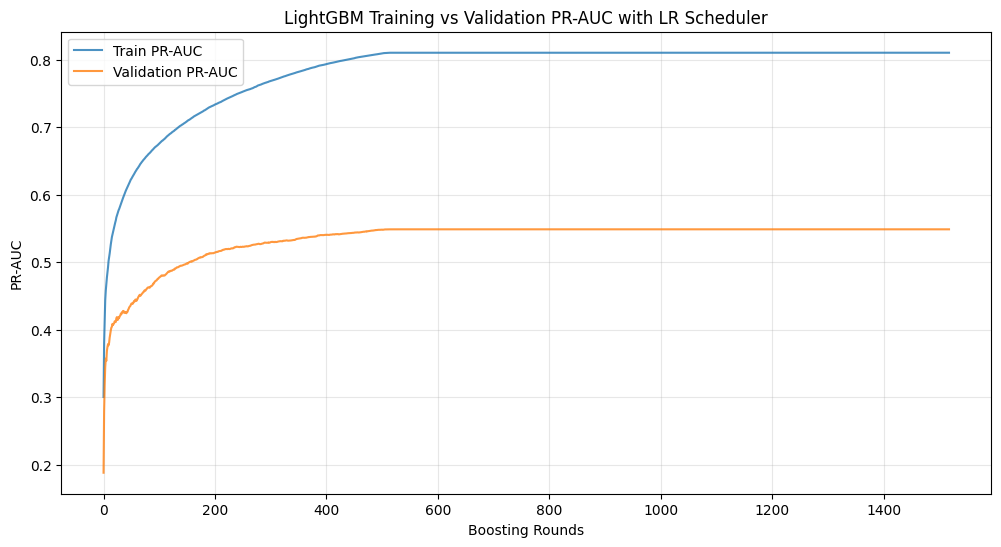

In [188]:
model_lgbm_anomaly = train_lgbm_manual(X_train_anomaly, y_train, X_valid_anomaly, y_valid, early_stopping_rounds=1000)

In [189]:
evaluate_and_log(model_lgbm_anomaly, X_valid_anomaly, y_valid, experiment_name="fraud_detection_kaggle", run_name="LGBM_Anomaly")

[INFO] Logged metrics: {'roc_auc': 0.9218129114053093, 'pr_auc': 0.5486060122083045, 'precision': 0.7151572031909902, 'recall': 0.375, 'f1': 0.49200968523002414, 'custom_loss': 2.1557134148406543}
[INFO] Logged SHAP summary plot.
[INFO] Evaluation complete and logged.


{'roc_auc': 0.9218129114053093,
 'pr_auc': 0.5486060122083045,
 'precision': 0.7151572031909902,
 'recall': 0.375,
 'f1': 0.49200968523002414,
 'custom_loss': 2.1557134148406543}

In [192]:
import shutil
shutil.make_archive("mlruns", 'zip', "/kaggle/working/mlruns")

'/kaggle/working/mlruns.zip'

# Test Submission

In [128]:
X_test_anomaly['isFraud'] = model_xgb_reduced.predict_proba(X_test_anomaly.drop(columns=['TransactionID'], axis=0))[:,1]

In [129]:
X_test_anomaly[['TransactionID', 'isFraud']].to_csv('/kaggle/working/submission.csv', index=False)